In [1]:
# handling data
import pandas as pd
import numpy as np

# plotting and statistics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

# validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

# datetime columns
from datetime import datetime # for datetime columns
import calendar # for datetime fix function

# datascraping for state - state code mapper
import requests # for datascrape
from bs4 import BeautifulSoup # datascrape

# data imputation with MissForest
import sklearn.neighbors._base
import sys 
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest # data imputation

# data imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

# under and over sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# feature creation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import clone

# to save the model
import pickle


# Outline
- Small overview of the data for pre-processing
- Remove Columns that Provide No Value
- Categorical Data
    - CUST_ZIP - Zip Code of Residence
    - CARR_NAME, STATE_PRVNC_TXT, RGN_NAME
    - create CUST_STATE same as STATE_PRVNC_TXT boolean
    - DVC_TYPE_TXT, AUTHC_PRIM_TYPE_CD, AUTHC_SCNDRY_STAT_TXT, ALERT_TRGR_CD, CUST_STATE
- Numerical Data
    - TRAN_TS
    - TRAN_DT
    - CUST_SINCE_DT, PWD_UPDT_TS, and PH_NUM_UPDT_TS
- Handle Missing Values
- Feature Selection
    - Non-Polynomial Features
        - Univariate 
        - Feature Importances
        - Correlation Heatmap
    - Polynomial Features
        - Univariate 
        - Feature Importances
        - Correlation Heatmap
    - Distributions
    - Select Features
- Model Testing and Selection

In [2]:
# load in data
old_data = pd.read_excel("Trainset.xlsx")
data = old_data.copy()

In [3]:
data.info

<bound method DataFrame.info of        TRAN_AMT  ACCT_PRE_TRAN_AVAIL_BAL  CUST_AGE  OPEN_ACCT_CT  WF_dvc_age  \
0          5.38                 23619.91        47             4        2777   
1         65.19                     0.00        45             5        2721   
2         54.84                 34570.63        36             8        1531   
3          0.01                     0.00        62             3         835   
4        497.08                 12725.18        81             2        1095   
...         ...                      ...       ...           ...         ...   
13995   1937.21                   230.75        55             4         142   
13996    114.38                     0.00        44            10         272   
13997    493.00                  2848.63        54             3         517   
13998    491.64                  3163.25        21             3           0   
13999      6.02                     0.00        60             6         944   

       

# Small overview of the data for pre-processing

In [4]:
data.head()

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,...,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,SCHPMT,P2P_COMMIT,P2P,5/3/2021,Non-Fraud
1,65.19,0.00,45,5,2721,NaN,charter communications,southwest,california,MOBL,...,CA,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,SCHPMT,P2P_COMMIT,P2P,1/13/2021,Non-Fraud
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,utah broadband llc,mountain,utah,ONLN,...,MD,5/5/2019 1:8:39,1994-02-01,4/8/2021 9:42:51,4/8/2021,SCHPMT,P2P_COMMIT,P2P,4/8/2021,Fraud
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,t-mobile usa inc.,southwest,california,MOBL,...,NV,2/16/2019 6:45:37,2001-11-01,8/10/2021 15:28:31,8/10/2021,SCHPMT,P2P_COMMIT,P2P,8/10/2021,Non-Fraud
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,cogent communications,south central,texas,MOBL,...,UT,5/8/2020 10:27:6,1987-02-07,6/27/2021 11:12:44,6/27/2021,SCHPMT,P2P_COMMIT,P2P,6/27/2021,Fraud


In [5]:
# look at the datatypes
data.dtypes

TRAN_AMT                          float64
ACCT_PRE_TRAN_AVAIL_BAL           float64
CUST_AGE                            int64
OPEN_ACCT_CT                        int64
WF_dvc_age                          int64
PWD_UPDT_TS                        object
CARR_NAME                          object
RGN_NAME                           object
STATE_PRVNC_TXT                    object
ALERT_TRGR_CD                      object
DVC_TYPE_TXT                       object
AUTHC_PRIM_TYPE_CD                 object
AUTHC_SCNDRY_STAT_TXT              object
CUST_ZIP                            int64
CUST_STATE                         object
PH_NUM_UPDT_TS                     object
CUST_SINCE_DT              datetime64[ns]
TRAN_TS                            object
TRAN_DT                            object
ACTN_CD                            object
ACTN_INTNL_TXT                     object
TRAN_TYPE_CD                       object
ACTVY_DT                           object
FRAUD_NONFRAUD                    

In [6]:
# number of nan values in each feature
data.isna().sum()

TRAN_AMT                      0
ACCT_PRE_TRAN_AVAIL_BAL       0
CUST_AGE                      0
OPEN_ACCT_CT                  0
WF_dvc_age                    0
PWD_UPDT_TS                3125
CARR_NAME                  2709
RGN_NAME                   2709
STATE_PRVNC_TXT            2709
ALERT_TRGR_CD                 0
DVC_TYPE_TXT               1761
AUTHC_PRIM_TYPE_CD            0
AUTHC_SCNDRY_STAT_TXT        74
CUST_ZIP                      0
CUST_STATE                   36
PH_NUM_UPDT_TS             7061
CUST_SINCE_DT                 0
TRAN_TS                       0
TRAN_DT                       0
ACTN_CD                       0
ACTN_INTNL_TXT                0
TRAN_TYPE_CD                  0
ACTVY_DT                      0
FRAUD_NONFRAUD                0
dtype: int64

# Remove Columns that Provide No Value

### ACTVY_DT is the same as TRAN_DT
#### We can drop ACTVY_DT as it provides no additional information
### All values of TRAN_TYPE_CD, ACTN_INTNL_TXT, and ACTN_CD are P2P, P2P_COMMIT, and SCHPMT respectively
#### Since there are no unique values, we can safely delete as they provide no useful information

In [7]:
# show that value counts are only 1 value
print("ACTVY_DT == TRAN_DT:\n",(old_data.ACTVY_DT == old_data.TRAN_DT).value_counts())
print("\nTRAN_TYPE_CD:\n", old_data.TRAN_TYPE_CD.value_counts())
print("\nACTN_INTNL_TXT\n", old_data.ACTN_INTNL_TXT.value_counts())
print("\nACTN_CD:\n",old_data.ACTN_CD.value_counts())

# drop all these useless columns
drop_col = ["ACTVY_DT", "TRAN_TYPE_CD", "ACTN_INTNL_TXT", "ACTN_CD"]
data.drop(drop_col, axis = 1, inplace=True)
print(old_data.shape, data.shape) # columns dropped

ACTVY_DT == TRAN_DT:
 True    14000
dtype: int64

TRAN_TYPE_CD:
 P2P    14000
Name: TRAN_TYPE_CD, dtype: int64

ACTN_INTNL_TXT
 P2P_COMMIT    14000
Name: ACTN_INTNL_TXT, dtype: int64

ACTN_CD:
 SCHPMT    14000
Name: ACTN_CD, dtype: int64
(14000, 24) (14000, 20)


In [8]:
data.head()

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,DVC_TYPE_TXT,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,NaN,UN_PWD,ALLOW,89002,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,Non-Fraud
1,65.19,0.00,45,5,2721,NaN,charter communications,southwest,california,MOBL,NaN,FACE_ID,ALLOW,94541,CA,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,Non-Fraud
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,utah broadband llc,mountain,utah,ONLN,DESKTOP,UN_PWD,ALLOW,21811,MD,5/5/2019 1:8:39,1994-02-01,4/8/2021 9:42:51,4/8/2021,Fraud
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,t-mobile usa inc.,southwest,california,MOBL,MOBILE,UN_PWD,ALLOW,89822,NV,2/16/2019 6:45:37,2001-11-01,8/10/2021 15:28:31,8/10/2021,Non-Fraud
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,cogent communications,south central,texas,MOBL,MOBILE,UN_PWD,CHALLENGE_SUCCESS,84108,UT,5/8/2020 10:27:6,1987-02-07,6/27/2021 11:12:44,6/27/2021,Fraud


# Categorical Data

### Print Number of Unique Values of Each Categorical Column

In [9]:
cat_cols = ["CARR_NAME", "RGN_NAME", "STATE_PRVNC_TXT", "ALERT_TRGR_CD", "DVC_TYPE_TXT", "AUTHC_PRIM_TYPE_CD", "AUTHC_SCNDRY_STAT_TXT", "CUST_ZIP", "CUST_STATE"]
print("Number of Unique Values for each Categoical Column:\n")
for col in cat_cols:
    print("{}: ".format(col), len(data[col].unique()))

Number of Unique Values for each Categoical Column:

CARR_NAME:  555
RGN_NAME:  20
STATE_PRVNC_TXT:  128
ALERT_TRGR_CD:  2
DVC_TYPE_TXT:  5
AUTHC_PRIM_TYPE_CD:  5
AUTHC_SCNDRY_STAT_TXT:  4
CUST_ZIP:  4064
CUST_STATE:  49


In [10]:
pd.set_option("display.max_rows", None)

In [11]:
data["CARR_NAME"].value_counts()

cox communications inc.                                                           1278
t-mobile usa  inc.                                                                1146
charter communications inc                                                        1145
comcast                                                                           1063
comcast cable communications  llc                                                  892
centurylink communications  llc                                                    860
frontier communications of america  inc.                                           801
att services inc                                                                   548
charter communications                                                             499
at&t mobility llc                                                                  426
cellco partnership dba verizon wireless                                            402
mci communications services  inc. d/b/a ver

In [12]:
# hawaii is the last state shown, so anything less than 9 is put into one category
data["STATE_PRVNC_TXT"].value_counts()

california              5438
arizona                 1235
texas                   1234
nevada                   450
new york                 369
colorado                 243
florida                  212
minnesota                171
georgia                  127
washington               122
illinois                 107
utah                     102
north carolina            79
virginia                  79
new mexico                75
new jersey                74
oregon                    67
iowa                      62
nebraska                  54
maryland                  52
pennsylvania              51
idaho                     48
tennessee                 42
south carolina            39
district of columbia      39
missouri                  38
oklahoma                  36
montana                   33
wisconsin                 31
alabama                   29
ohio                      26
kansas                    26
michigan                  25
louisiana                 24
massachusetts 

In [13]:
data["RGN_NAME"].value_counts()

southwest              7123
south central          1346
southeast               572
mountain                467
northeast               419
great lakes             360
mid atlantic            301
pacific northwest       256
unknown                 241
midwest                 184
pacific                   9
ile-de-france             3
south east                3
pays de la loire          2
comunidad de madrid       1
leinster                  1
west coast                1
north west                1
central canada            1
Name: RGN_NAME, dtype: int64

In [14]:
data["DVC_TYPE_TXT"].value_counts()

MOBILE     8796
DESKTOP    2986
TABLET      238
PHONE       219
Name: DVC_TYPE_TXT, dtype: int64

In [15]:
data["AUTHC_PRIM_TYPE_CD"].value_counts()

UN_PWD      10536
FACE_ID      1953
AFA_PL        720
TOUCH_ID      701
AFA_BM         90
Name: AUTHC_PRIM_TYPE_CD, dtype: int64

In [16]:
data["AUTHC_SCNDRY_STAT_TXT"].value_counts()

ALLOW                13193
CHALLENGE_SUCCESS      646
CHALLENGE_ISSUED        87
Name: AUTHC_SCNDRY_STAT_TXT, dtype: int64

In [17]:
data["ALERT_TRGR_CD"].value_counts()

MOBL    7110
ONLN    6890
Name: ALERT_TRGR_CD, dtype: int64

In [18]:
data["CUST_STATE"].value_counts()

CA    4570
TX    2368
AZ    1288
FL     914
NV     535
CO     477
MN     452
GA     304
OR     222
WA     222
NJ     215
NM     205
NC     179
UT     171
NY     156
VA     139
ID     124
SC     111
PA     110
IA     109
IL      98
WI      97
NE      94
MD      89
MT      79
SD      76
AK      71
AL      55
TN      51
CT      47
MO      44
WY      32
OH      26
MS      24
DE      24
MI      23
ND      22
KS      22
LA      20
IN      19
DC      16
OK      16
AR      13
HI      13
KY       8
WV       5
ME       5
GU       4
Name: CUST_STATE, dtype: int64

#### From above, we need to deal with CARR_NAME, STATE_PRVNC_TXT, RGN_NAME, CUST_ZIP individually before ordinal encoding of each column there are extra 'unknown' values in these categories (not including CUST_ZIP
#### The categorical columns with missing values (nan) are CARR_NAME, RGN_NAME, STATE_PRVNC_TXT, DVC_TYPE_TXT, AUTHC_SCNDRY_STAT_TXT, CUST_STATE

#### Another feature can be created by mapping CUST_STATE and STATE_PRVNC_TXT to the same values and then binary 1 or 0 if they are the same

In [19]:
# Fill all categorical column Nan values with "Unknown"
data[cat_cols] = old_data[cat_cols].fillna("Unknown")

In [20]:
pd.set_option("display.max_rows",10)

### CUST_ZIP - Zip Code of Residence
#### Remove the last four digits of the zip code, leaving only the first digit which represents the geographical region in the US

In [21]:
data["CUST_ZIP"] = old_data["CUST_ZIP"]//10000

In [22]:
data["CUST_ZIP"].unique()

array([8, 9, 2, 7, 1, 0, 3, 5, 4, 6])

### CARR_NAME, STATE_PRVNC_TXT, RGN_NAME
#### Replace 'unknown' and 'none' values with "Unknown"
#### Ordinal encode - every value with a count less than a certain value will go into an 'other' category

In [23]:
# replace 'unknown' and 'none' values with 'Unknown'
data.loc[data["CARR_NAME"] == "unknown", "CARR_NAME"] = "Unknown"
data.loc[data["RGN_NAME"] == "unknown", "RGN_NAME"] = "Unknown"
data.loc[(data["STATE_PRVNC_TXT"] == "none") | (data["STATE_PRVNC_TXT"] == "unknown"), "STATE_PRVNC_TXT"] = "Unknown"

In [24]:
# ordinal encode every value with a count less than a certain value going into "other" category
cat_col_special = ["CARR_NAME", "STATE_PRVNC_TXT", "RGN_NAME"]
cat_col_other_cond = [10,9,9] # threshold for values to keep

# categorize values with more than cat_col_other_cond occurrences and put rest into one category
for i, col in enumerate(cat_col_special):
    mask = data[col].map(data[col].value_counts()) < cat_col_other_cond[i]
    data[col] = data[col].mask(mask, "other") # rename as other

In [25]:
for col in cat_col_special:
    print("Num categories for {}: ".format(col), len(data[col].value_counts()))

Num categories for CARR_NAME:  49
Num categories for STATE_PRVNC_TXT:  49
Num categories for RGN_NAME:  12


## create IN_STATE = CUST_STATE same as STATE_PRVNC_TXT boolean

In [26]:
url = "https://www23.statcan.gc.ca/imdb/p3VD.pl?Function=getVD&TVD=53971"
headers = {"User-Agent" : "Chrome/97.0.4692.71"} # chrome browser being used

page = requests.get(url, headers=headers) # get page information
page_content = page.content
soup = BeautifulSoup(page_content,'html.parser')

# get the html
table = soup.find_all("table", {"class":"table table-bordered responsive-utilities table-hover table-condensed mrgn-bttm-0"})

# create map between state and state code (i.e. arizona is AZ)
stateDict = {}
for row in soup.select("tr")[1:]:
    myRow = row.find_all("td")
    state = myRow[0].text.strip().lower()
    code = myRow[2].text.strip().upper()
    stateDict[state] = code
    
data["IN_STATE"] = data["STATE_PRVNC_TXT"].replace(stateDict) == data["CUST_STATE"] # create IN_STATE category
cat_cols.append("IN_STATE")

### DVC_TYPE_TXT, AUTHC_PRIM_TYPE_CD, AUTHC_SCNDRY_STAT_TXT, ALERT_TRGR_CD, CUST_STATE -- These look good -- can perform ordinal encoding on all AFTER PERFORMING IMPUTATION

In [27]:
data.head()

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,FRAUD_NONFRAUD,IN_STATE
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,...,UN_PWD,ALLOW,8,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,Non-Fraud,True
1,65.19,0.00,45,5,2721,NaN,charter communications,southwest,california,MOBL,...,FACE_ID,ALLOW,9,CA,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,Non-Fraud,True
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,other,mountain,utah,ONLN,...,UN_PWD,ALLOW,2,MD,5/5/2019 1:8:39,1994-02-01,4/8/2021 9:42:51,4/8/2021,Fraud,False
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,t-mobile usa inc.,southwest,california,MOBL,...,UN_PWD,ALLOW,8,NV,2/16/2019 6:45:37,2001-11-01,8/10/2021 15:28:31,8/10/2021,Non-Fraud,False
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,cogent communications,south central,texas,MOBL,...,UN_PWD,CHALLENGE_SUCCESS,8,UT,5/8/2020 10:27:6,1987-02-07,6/27/2021 11:12:44,6/27/2021,Fraud,False


In [28]:
# ordinal encoded value for unknown
unknown_encoded = 9999

for col in cat_cols:
    # put all unique values into list
    myList = data[col].unique()
    
    # dictionary to map values to encoded integers by index
    mapper = dict(map(reversed,enumerate(myList))) 
    
    # replace Unknown encoded value with high specific number to differentiate and use for imputation
    if "Unknown" in myList:
        mapper["Unknown"] = unknown_encoded
    
    # map to encoded values
    data[col] = data[col].replace(mapper)

<ipython-input-28-261a9df786e4>:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "Unknown" in myList:


In [29]:
for col in cat_cols:
    print("Num categories for {}: ".format(col), len(data[col].value_counts()))

Num categories for CARR_NAME:  49
Num categories for RGN_NAME:  12
Num categories for STATE_PRVNC_TXT:  49
Num categories for ALERT_TRGR_CD:  2
Num categories for DVC_TYPE_TXT:  5
Num categories for AUTHC_PRIM_TYPE_CD:  5
Num categories for AUTHC_SCNDRY_STAT_TXT:  4
Num categories for CUST_ZIP:  10
Num categories for CUST_STATE:  49
Num categories for IN_STATE:  2


In [30]:
pd.set_option("display.max_rows", 10)

In [31]:
data.head()

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,AUTHC_PRIM_TYPE_CD,AUTHC_SCNDRY_STAT_TXT,CUST_ZIP,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,FRAUD_NONFRAUD,IN_STATE
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,0,0,0,0,...,0,0,0,0,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,Non-Fraud,0
1,65.19,0.00,45,5,2721,NaN,1,0,1,0,...,1,0,1,1,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,Non-Fraud,0
2,54.84,34570.63,36,8,1531,12/22/2021 10:42:51,2,1,2,1,...,0,0,2,2,5/5/2019 1:8:39,1994-02-01,4/8/2021 9:42:51,4/8/2021,Fraud,1
3,0.01,0.00,62,3,835,2/8/2020 7:28:31,3,0,1,0,...,0,0,0,0,2/16/2019 6:45:37,2001-11-01,8/10/2021 15:28:31,8/10/2021,Non-Fraud,1
4,497.08,12725.18,81,2,1095,12/28/2020 12:12:44,4,2,3,0,...,0,1,0,3,5/8/2020 10:27:6,1987-02-07,6/27/2021 11:12:44,6/27/2021,Fraud,1


# Numerical Data

### PWD_UPDT_TS, PH_NUM_UPDT_TS, TRAN_TS all contain NaN values. Dates and times also need to be split.
### The following are dates and/or times and need to be turned into suitable values with useful information PWD_UPDT_TS, PH_NUM_UPDT_TS, CUST_SINCE_DT, TRAN_TS, TRAN_DT
### The rest can be unaltered: TRAN_AM, ACCT_PRE_TRAN_AVAIL_BA, CUST_AGE, OPEN_ACCT_CT, WF_dvc_age 

## Convert TRAN_TS to numerical values

In [32]:
# feature transformation --> TRAN_TS has (5/3/2021, 18:3:58) --> only need 18:3:58 (time)
data.TRAN_TS = data.TRAN_TS.str.split(expand=True)[1]

heads = ["TRAN_TS_Hour", "TRAN_TS_Minute", "TRAN_TS_Second"] # split times (to be put back together)
data[heads] = data.TRAN_TS.str.split(":", expand=True)
for col in heads:
    data[col] = data[col].apply(str)
    data[col] = data[col].apply(float)
    
# remove original (TRAN_TS) column
data.drop(["TRAN_TS"], inplace=True, axis = 1)
    
# THIS WAS TO COMBINE INTO ONE COLUMN -> BUT LEAVE AS THREE
# data["TRAN_TS"] = data["TRAN_TS_Hour"] + data["TRAN_TS_Minute"] / 60 + data["TRAN_TS_Second"] / 3600
# data.drop(heads, axis = 1, inplace=True)

## TRAN_DT --> don't need 2021 b/c 2021 appears in all --> split into monthly and daily values --> a higher occurrence of fraud might be seasonal

In [33]:
heads = ["TRAN_DT_M", "TRAN_DT_D", "TRAN_DT_Y"]
data[heads] = data.TRAN_DT.str.split("/", expand=True)
print(data.TRAN_DT_Y.value_counts().sum()) # show that 2021 or nan is part of every year column

# for some reason, there are some values that are datetime objects --> convert to string object in correct format
data.loc[data["TRAN_DT_Y"] != "2021", "TRAN_DT"] = data.loc[data["TRAN_DT_Y"] != "2021", "TRAN_DT"].apply(lambda x: x.strftime('%m/%d/%Y'))
#data.loc[data["TRAN_DT_Y"] != "2021", heads] = data.loc[data["TRAN_DT_Y"] != "2021", "TRAN_DT"].str.split("/",expand=True)
data[heads] = data.TRAN_DT.str.split("/", expand=True)

# show that there is only 2021 in the year column now
print(data.TRAN_DT_Y.value_counts().sum()) # show that 2021 or nan is part of every year column


# replace TRAN_DT with numerical value of month and day (range of 0-13)
data["TRAN_DT_M"] = data["TRAN_DT_M"].apply(float)
data["TRAN_DT_D"] = data["TRAN_DT_D"].apply(float)

# drop original (TRAN_DT) column
data.drop(["TRAN_DT", "TRAN_DT_Y"], inplace= True, axis=1)


#LEAVE AS SEPARATE COLUMNS
# data["TRAN_DT"] = data["TRAN_DT_M"] + data["TRAN_DT_D"] / 30 # can use an estimate of 30 for time of month

# # drop the additional columns (heads)
# data.drop(heads,axis=1, inplace=True)

13865
14000


## CUST_SINCE_DT, PWD_UPDT_TS, and PH_NUM_UPDT_TS to number of years (from datetime) with value being number of years since today

In [34]:
data["CUST_SINCE_YRS"] = datetime.today() - data["CUST_SINCE_DT"] # time in days with newest customer being first
data["CUST_SINCE_YRS"] = data["CUST_SINCE_YRS"].apply(lambda x: x.days/365) # time in years (integer)

#### This function converts a datetime in form of string to datetime value and handles exception of day not being correct for the month 

In [35]:
def fix(x):
    try:
        return datetime.strptime(x, "%m/%d/%Y %H:%M:%S") # convert to string
    except ValueError:
        # Oops, invalid date. Assume we can fix this by shifting this to the next month instead
        month = int(x.split('/')[0])
        year = int(x.split('/')[2].split(' ')[0])
        day = int(x.split('/')[1])

        _, monthdays = calendar.monthrange(year, month) # check if inside number of days for given month
        if monthdays < day:
            surplus = day - monthdays # add extra days to next month
            x = x.replace(x.split('/')[1], str(surplus))
            x = x.replace(x.split('/')[0], str(month + 1))
            return datetime.strptime(x, "%m/%d/%Y %H:%M:%S") # convert to string

In [36]:
# convert to number of days since
old_name = ["PWD_UPDT_TS", "PH_NUM_UPDT_TS"]
new_name = ["PWD_UPDT_SINCE", "PH_NUM_UPDT_SINCE"]

for i, col in enumerate(old_name):
    data.loc[data[col].notnull(), col] = data.loc[data[col].notnull(), col].apply(fix) # convert to strings
    data.loc[data[col].notnull(), new_name[i]] = datetime.today() - data[col] # length of time since updating
    data[new_name[i]] = data[new_name[i]].apply(lambda x: x.days/365) # convert to years

In [37]:
old_name.append("CUST_SINCE_DT")
data.drop(old_name,axis=1,inplace=True)

In [38]:
data

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,DVC_TYPE_TXT,...,FRAUD_NONFRAUD,IN_STATE,TRAN_TS_Hour,TRAN_TS_Minute,TRAN_TS_Second,TRAN_DT_M,TRAN_DT_D,CUST_SINCE_YRS,PWD_UPDT_SINCE,PH_NUM_UPDT_SINCE
0,5.38,23619.91,47,4,2777,0,0,0,0,9999,...,Non-Fraud,0,18.0,3.0,58.0,5.0,3.0,29.339726,4.293151,1.183562
1,65.19,0.00,45,5,2721,1,0,1,0,9999,...,Non-Fraud,0,19.0,19.0,37.0,1.0,13.0,51.353425,NaN,NaN
2,54.84,34570.63,36,8,1531,2,1,2,1,1,...,Fraud,1,9.0,42.0,51.0,4.0,8.0,28.268493,0.358904,2.997260
3,0.01,0.00,62,3,835,3,0,1,0,2,...,Non-Fraud,1,15.0,28.0,31.0,8.0,10.0,20.515068,2.232877,3.210959
4,497.08,12725.18,81,2,1095,4,2,3,0,2,...,Fraud,1,11.0,12.0,44.0,6.0,27.0,35.257534,1.342466,1.983562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,1937.21,230.75,55,4,142,8,0,1,0,2,...,Non-Fraud,0,12.0,11.0,59.0,3.0,12.0,20.923288,NaN,4.802740
13996,114.38,0.00,44,10,272,3,0,1,0,2,...,Non-Fraud,1,9.0,28.0,20.0,6.0,11.0,11.923288,4.501370,NaN
13997,493.00,2848.63,54,3,517,16,0,1,0,1,...,Fraud,1,12.0,31.0,15.0,5.0,16.0,37.539726,0.912329,0.939726
13998,491.64,3163.25,21,3,0,9999,9999,9999,1,1,...,Fraud,1,12.0,34.0,54.0,5.0,11.0,1.172603,2.167123,NaN


In [39]:
pd.set_option("display.max_rows", None)
data.isna().sum()

TRAN_AMT                      0
ACCT_PRE_TRAN_AVAIL_BAL       0
CUST_AGE                      0
OPEN_ACCT_CT                  0
WF_dvc_age                    0
CARR_NAME                     0
RGN_NAME                      0
STATE_PRVNC_TXT               0
ALERT_TRGR_CD                 0
DVC_TYPE_TXT                  0
AUTHC_PRIM_TYPE_CD            0
AUTHC_SCNDRY_STAT_TXT         0
CUST_ZIP                      0
CUST_STATE                    0
FRAUD_NONFRAUD                0
IN_STATE                      0
TRAN_TS_Hour                135
TRAN_TS_Minute              135
TRAN_TS_Second              135
TRAN_DT_M                     0
TRAN_DT_D                     0
CUST_SINCE_YRS                0
PWD_UPDT_SINCE             3125
PH_NUM_UPDT_SINCE          7563
dtype: int64

In [40]:
pd.set_option("display.max_rows", None)
data.dtypes

TRAN_AMT                   float64
ACCT_PRE_TRAN_AVAIL_BAL    float64
CUST_AGE                     int64
OPEN_ACCT_CT                 int64
WF_dvc_age                   int64
CARR_NAME                    int64
RGN_NAME                     int64
STATE_PRVNC_TXT              int64
ALERT_TRGR_CD                int64
DVC_TYPE_TXT                 int64
AUTHC_PRIM_TYPE_CD           int64
AUTHC_SCNDRY_STAT_TXT        int64
CUST_ZIP                     int64
CUST_STATE                   int64
FRAUD_NONFRAUD              object
IN_STATE                     int64
TRAN_TS_Hour               float64
TRAN_TS_Minute             float64
TRAN_TS_Second             float64
TRAN_DT_M                  float64
TRAN_DT_D                  float64
CUST_SINCE_YRS             float64
PWD_UPDT_SINCE             float64
PH_NUM_UPDT_SINCE          float64
dtype: object

In [41]:
pd.set_option("display.max_rows", 10)

# Handle Missing Values

In [42]:
# map FRAUD_NONFRAUD to binary (Fraud = 1, Non-Fraud = 0)
data["FRAUD_NONFRAUD"] = data["FRAUD_NONFRAUD"].replace({"Fraud":1, "Non-Fraud":0})

# move label to end of dataframe
temp = data["FRAUD_NONFRAUD"].copy()
data.drop("FRAUD_NONFRAUD", axis = 1, inplace=True)
data["FRAUD_NONFRAUD"] = temp

In [43]:
# fill/impute missing values with 0
dataFill = data.fillna(0)

# grab columns that contain NaN values
data = data.fillna(9999)

# IMPUTE MISSING DATA

# Impute values using MissForest
numImputer = MissForest(missing_values = 9999, criterion=('squared_error', 'gini')) # instantiate and replace set value
dataImp = numImputer.fit_transform(data[data.columns[0:-1]])
dataMF = pd.DataFrame(dataImp, columns = data.columns[0:-1]) # put into new dataframe


# Use experimental iterative imputer
itImputer = IterativeImputer(missing_values = 9999, random_state = 42)
itImputer.fit(data[data.columns[0:-1]])
dataImp = itImputer.transform(data[data.columns[0:-1]])
dataItImpute = pd.DataFrame(dataImp, columns = data.columns[0:-1]) # put into new dataframe

# use KNN imputer
knnImputer = KNNImputer(missing_values = 9999, n_neighbors = 4)
knnImputer.fit(data[data.columns[0:-1]])
dataImp = knnImputer.transform(data[data.columns[0:-1]])
dataKNNImpute = pd.DataFrame(dataImp, columns = data.columns[0:-1]) # put into new dataframe


### Place into list of dataframes so iteration through these is possible
# create list of imputed data
dataImpute = [data, dataFill, dataMF, dataItImpute, dataKNNImpute]

Iteration: 0
Iteration: 1


### Save the numeric columns and categorical columns

In [44]:
# select numeric columns
num_cols = data.select_dtypes(include=[np.float]).columns
# select non-numeric columns
cat_cols = data.select_dtypes(include=[np.int]).columns

# Feature Selection

In [45]:
# https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

## Non-Polynomial Features

### Univariate selection

In [46]:
# make sure that FRAUD_NONFRAUD is the last column
temp = data["FRAUD_NONFRAUD"]
data.drop("FRAUD_NONFRAUD", inplace=True, axis=1)
data["FRAUD_NONFRAUD"] = temp

In [47]:
def SelectKBestResults(X,y, numFeat = 10):
    bestfeatures = SelectKBest(score_func=chi2, k=numFeat)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(featureScores.nlargest(numFeat,'Score'))  #print 10 best features

In [48]:
# make sure that all values are positive
myMin = min(dataItImpute["WF_dvc_age"])
dataItImpute["WF_dvc_age"] = dataItImpute["WF_dvc_age"] + -1*myMin

X = dataItImpute #independent columns
y = data.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
SelectKBestResults(X, y, 10)

                      Specs          Score
0                  TRAN_AMT  580554.666854
1   ACCT_PRE_TRAN_AVAIL_BAL  171298.156571
4                WF_dvc_age  115847.355742
7           STATE_PRVNC_TXT   13141.655525
6                  RGN_NAME    3355.021537
13               CUST_STATE    1991.021970
16           TRAN_TS_Minute    1639.355991
21           PWD_UPDT_SINCE    1064.173255
5                 CARR_NAME     986.311486
3              OPEN_ACCT_CT     448.684962


### Feature importances

In [49]:
def FeatImportanceBestResults(X,y,model = RandomForestClassifier(), numFeat=10):
    model.fit(X,y)
    print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(numFeat).plot(kind='barh')
    plt.show()

[0.3118764  0.12679411 0.01504657 0.01595655 0.07898815 0.02609297
 0.05749027 0.09396421 0.00318629 0.03956331 0.00570693 0.00297674
 0.00622841 0.00890532 0.00442901 0.01305255 0.02602118 0.02152393
 0.00756287 0.0101682  0.01497748 0.05349265 0.05599589]


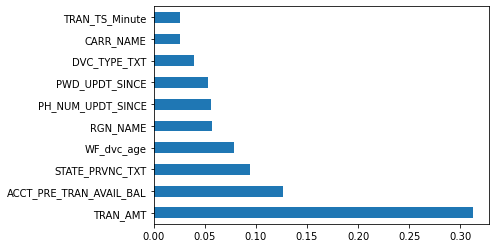

In [50]:
X = dataItImpute  #independent columns
y = data.iloc[:,-1]    #target column i.e price range

model = RandomForestClassifier()
FeatImportanceBestResults(X,y,model,10)

## Correlation Heatmap

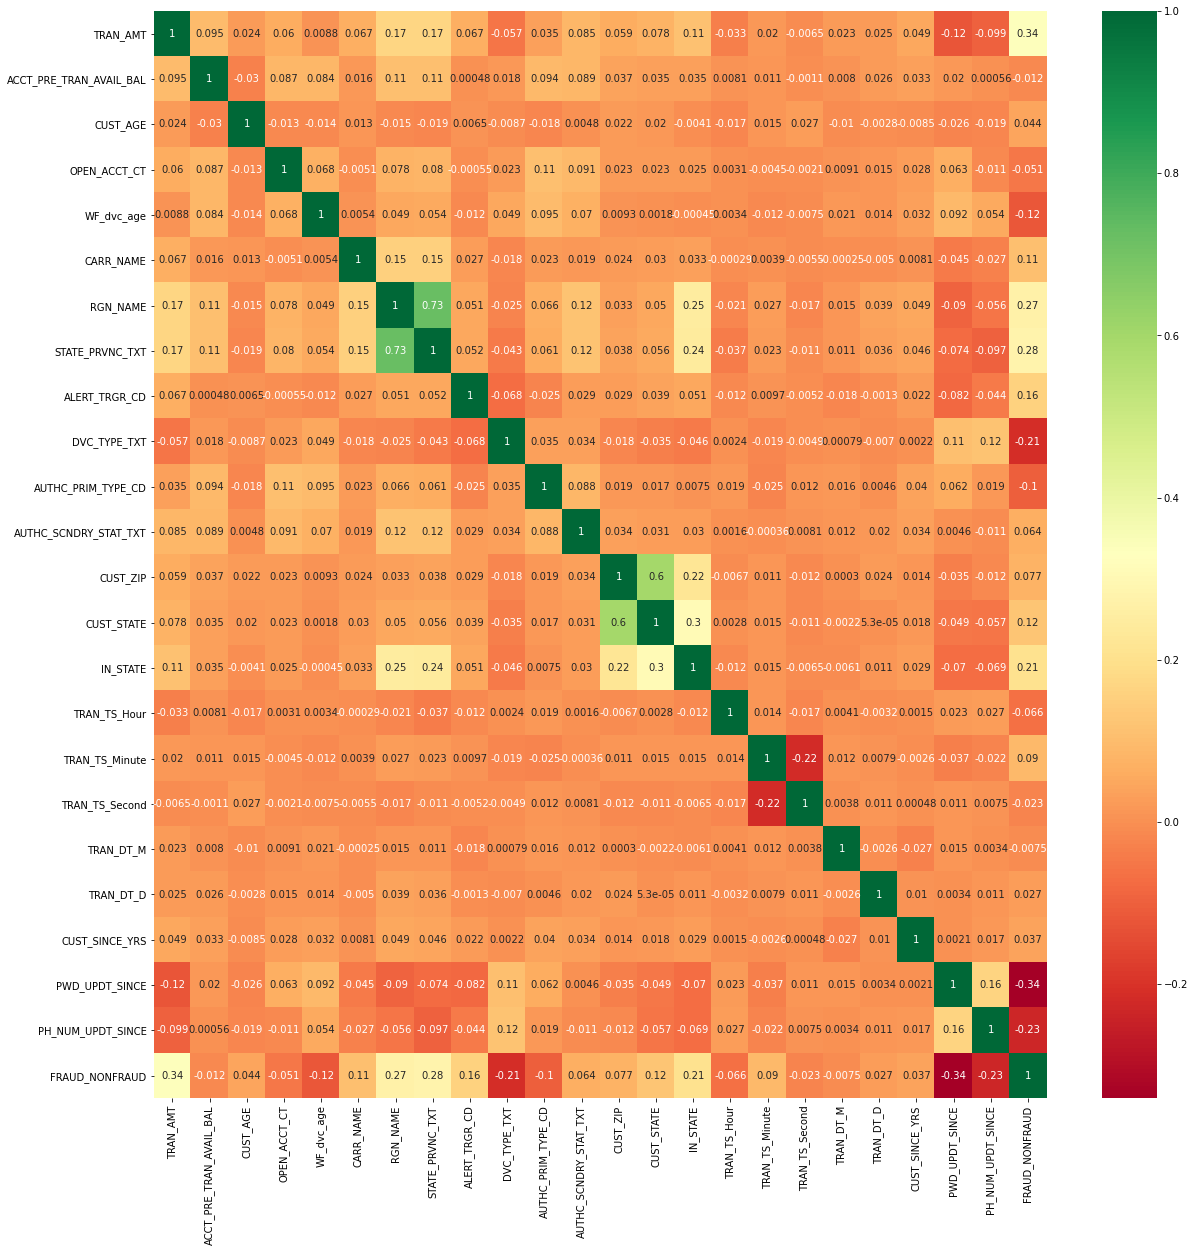

In [51]:
dataItImpute["FRAUD_NONFRAUD"] = data["FRAUD_NONFRAUD"].replace({"Fraud":1, "Non-Fraud":0})

import seaborn as sns
X = dataItImpute#independent columns
y = data.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = dataItImpute.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(dataItImpute[top_corr_features].corr(),annot=True,cmap="RdYlGn")

dataItImpute.drop(["FRAUD_NONFRAUD"], axis=1,inplace=True)


## Polynomial Features

In [52]:
# create dataframe with polynomial features
poly = PolynomialFeatures(2, include_bias = False)
polyDataItImp = poly.fit_transform(dataItImpute)
polyData = pd.DataFrame(polyDataItImp, columns = poly.get_feature_names_out(dataItImpute.columns))

### Univariate Selection

In [53]:
X = polyData #independent columns
y = data.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
SelectKBestResults(X, y, 10)

                                    Specs         Score
46              ACCT_PRE_TRAN_AVAIL_BAL^2  1.073398e+12
49     ACCT_PRE_TRAN_AVAIL_BAL WF_dvc_age  2.888692e+09
24       TRAN_AMT ACCT_PRE_TRAN_AVAIL_BAL  4.463951e+08
109                          WF_dvc_age^2  2.983809e+08
27                    TRAN_AMT WF_dvc_age  1.029960e+08
23                             TRAN_AMT^2  6.560661e+07
48   ACCT_PRE_TRAN_AVAIL_BAL OPEN_ACCT_CT  6.295207e+07
25                      TRAN_AMT CUST_AGE  3.452631e+07
39                TRAN_AMT TRAN_TS_Minute  2.126513e+07
40                TRAN_AMT TRAN_TS_Second  1.774527e+07


### Feature Importances

[8.04378581e-02 1.10572939e-02 1.15159945e-03 7.84688376e-04
 1.03694716e-02 1.15751755e-03 4.64817128e-03 1.33189734e-02
 6.23445420e-05 2.71409735e-03 3.56095041e-04 8.07611455e-05
 2.81853465e-04 5.56624228e-04 2.33951170e-05 7.34997338e-04
 1.19348071e-03 1.24712973e-03 2.86515497e-04 5.67234708e-04
 8.62924716e-04 5.10826017e-03 3.46564383e-03 9.02203057e-02
 2.81856443e-02 1.10865639e-02 3.26412562e-03 9.86524321e-03
 1.37557657e-02 1.72446480e-02 3.48372765e-02 1.91749720e-02
 3.98596172e-02 1.87622016e-03 2.33435252e-04 9.85850647e-03
 9.27025274e-03 4.38527848e-02 6.49124357e-03 6.91710489e-03
 3.80301836e-03 1.80684856e-02 4.78131874e-03 2.31759144e-03
 1.03925939e-02 7.65429333e-03 1.99485937e-02 4.70769815e-03
 3.74868872e-03 3.84636935e-03 6.73282978e-03 1.88881863e-02
 1.38605918e-02 1.30342811e-03 8.40872091e-03 6.50911479e-04
 3.53548995e-04 1.72607851e-03 4.54679935e-03 1.99291345e-02
 3.67471227e-03 8.30088592e-03 1.46126774e-03 3.90507734e-03
 3.00868602e-03 2.371145

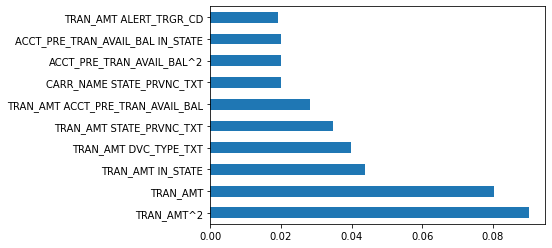

In [54]:
X = polyData  #independent columns
y = data.iloc[:,-1]    #target column i.e price range

model = RandomForestClassifier()
FeatImportanceBestResults(X,y,model,10)

### Correlations with Label

In [55]:
polyData["Label"] = data["FRAUD_NONFRAUD"].replace({"Fraud":1, "Non-Fraud":0})
corrmat = polyData.corr()
top_corr_features = corrmat.index
polyData[top_corr_features].corr()
polyData.drop(["Label"], axis=1,inplace=True)
abs(corrmat["Label"]).sort_values()[-11:-1]

TRAN_TS_Hour PWD_UPDT_SINCE         0.287791
TRAN_AMT TRAN_TS_Minute             0.297502
PWD_UPDT_SINCE^2                    0.300965
TRAN_AMT ALERT_TRGR_CD              0.309838
TRAN_AMT CUST_AGE                   0.316014
TRAN_AMT                            0.336169
PWD_UPDT_SINCE                      0.340583
DVC_TYPE_TXT PWD_UPDT_SINCE         0.358161
PWD_UPDT_SINCE PH_NUM_UPDT_SINCE    0.358417
TRAN_AMT IN_STATE                   0.370838
Name: Label, dtype: float64

#### Use the features with highest scores. Do not use features that are composed of the same features (i.e. do not use TRAN_AMT and TRAN_AMT IN_STATE, so that the model will stay simple and not have high correlation between used features.

## Distributions (numerical) and Histograms (categorical)

### We can see here that Non-Fraud is a little more than double Fraud -> keep this in mind when looking at the histograms and distributions

In [56]:
data["FRAUD_NONFRAUD"].value_counts()

0    9836
1    4164
Name: FRAUD_NONFRAUD, dtype: int64

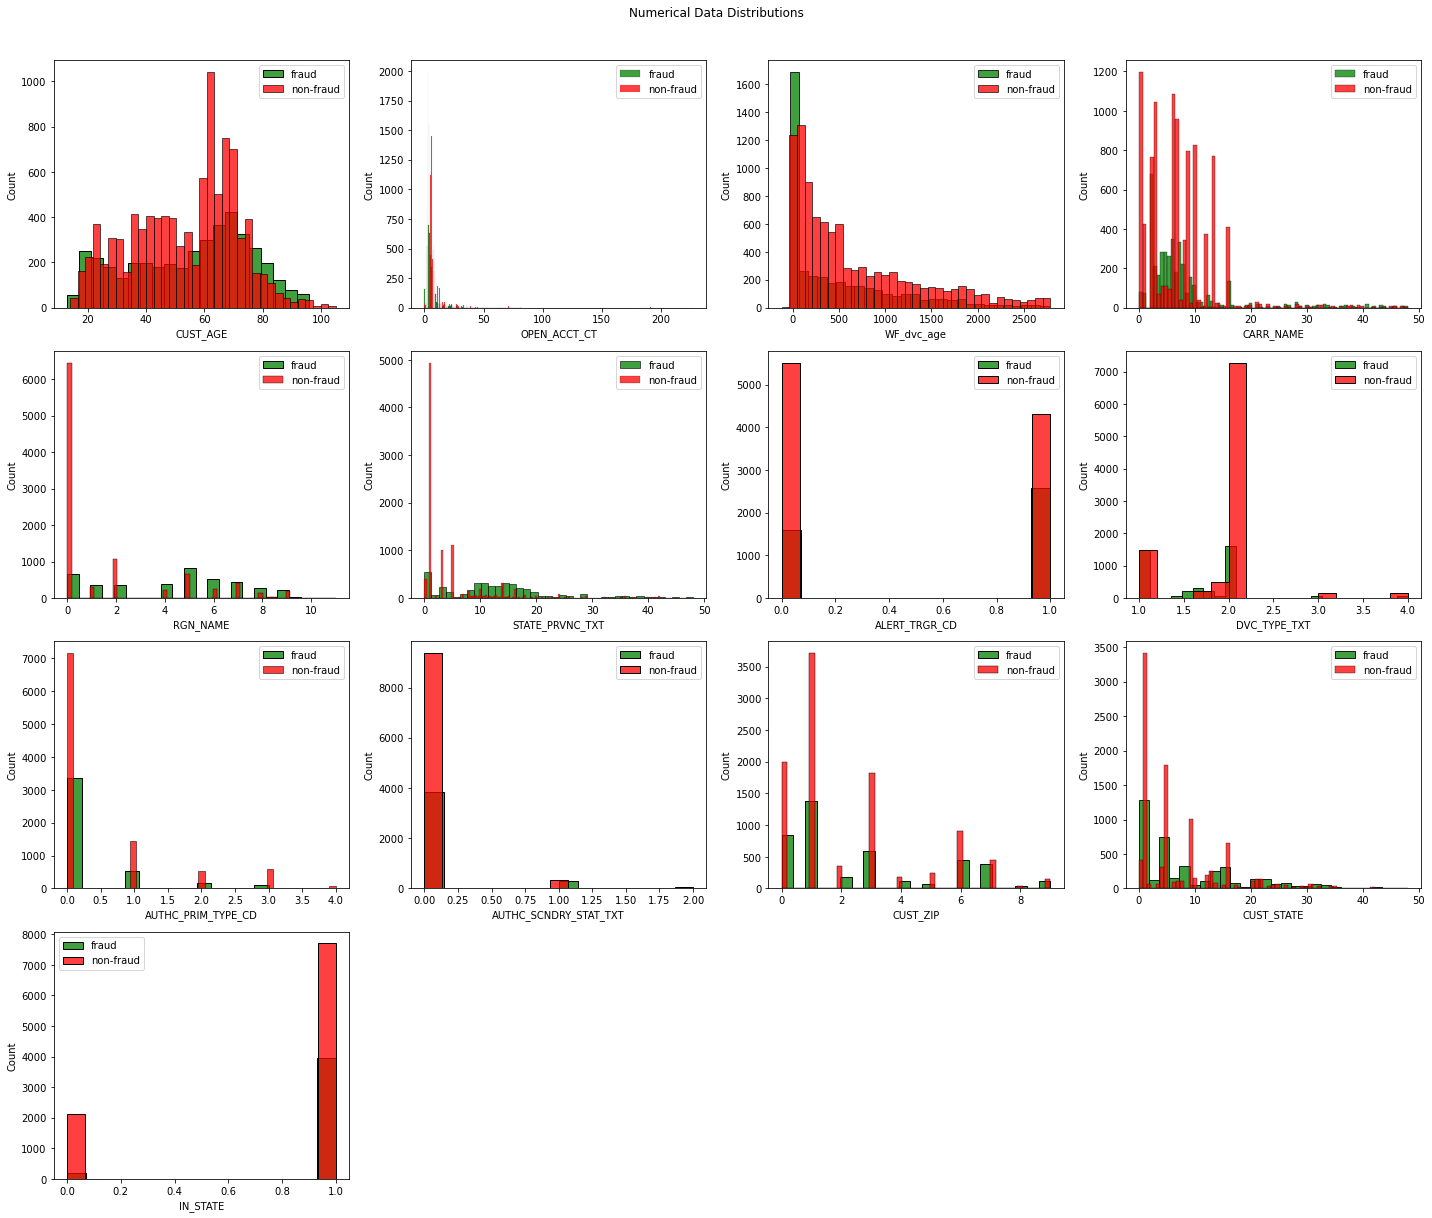

In [134]:
fig = plt.figure(figsize=(20,25))
j = 0
for i in cat_cols:
    plt.subplot(6,4,j+1)
    j=j+1
    sns.histplot(dataMF.loc[data["FRAUD_NONFRAUD"] == "Fraud", i], color = 'g', label = 'fraud')
    sns.histplot(dataMF.loc[data["FRAUD_NONFRAUD"] == "Non-Fraud", i], color='r', label='non-fraud')
    plt.legend(loc='best')
fig.suptitle("Categorical Histograms")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

/Users/jonathanwozny/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jonathanwozny/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jonathanwozny/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

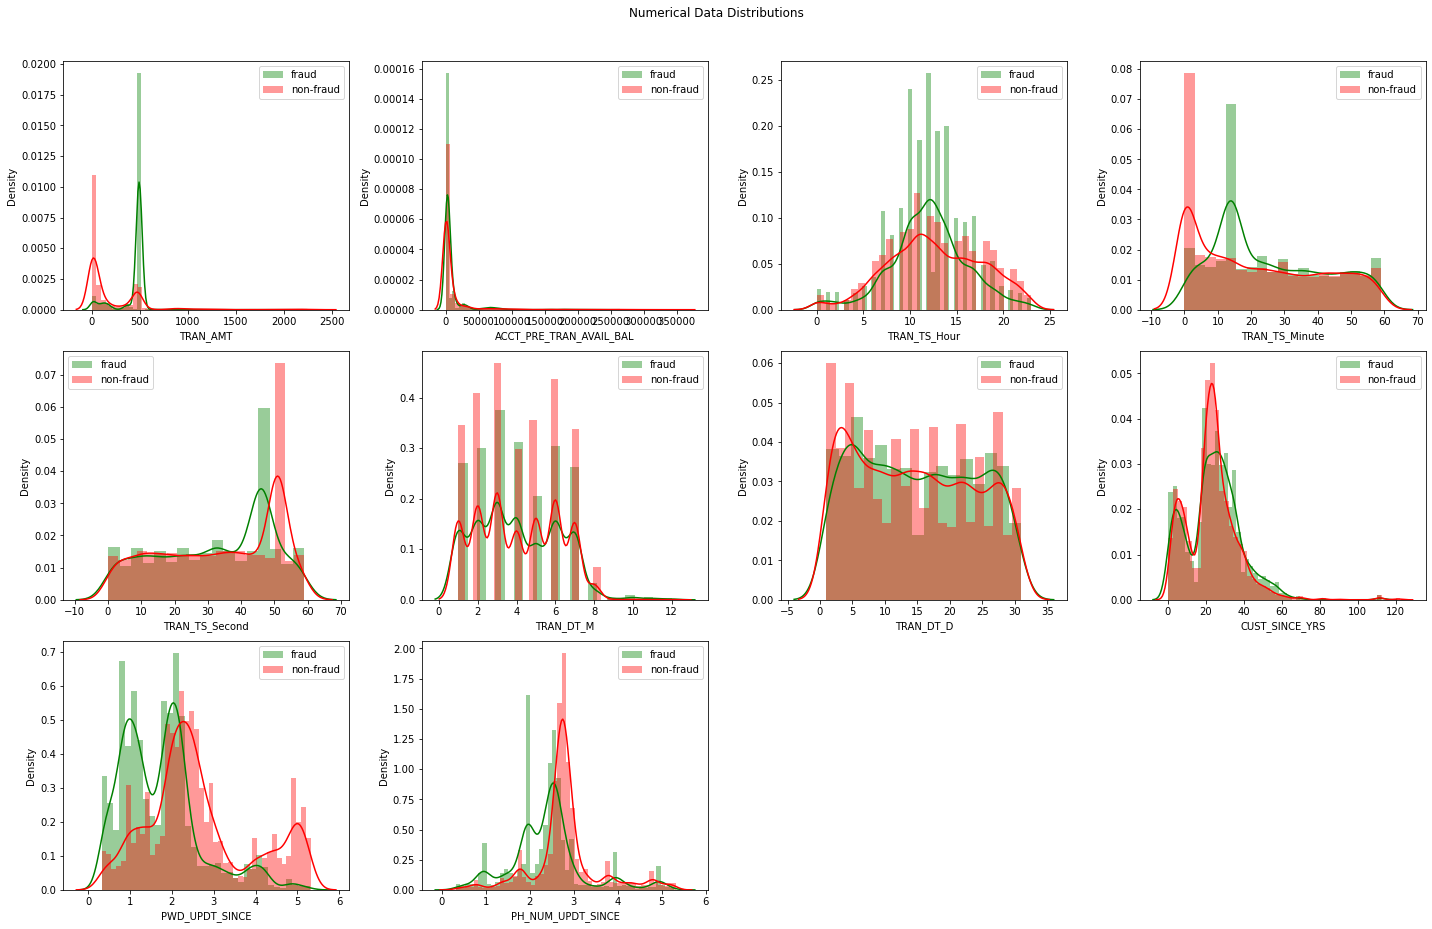

In [142]:
fig = plt.figure(figsize=(20,25))
j = 0
for i in num_cols:
    plt.subplot(6,4,j+1)
    j=j+1
    sns.distplot(dataItImpute.loc[data["FRAUD_NONFRAUD"] == "Fraud", i], color = 'g', label = 'fraud')
    sns.distplot(dataItImpute.loc[data["FRAUD_NONFRAUD"] == "Non-Fraud", i], color='r', label='non-fraud')
    plt.legend(loc='best')
fig.suptitle("Numerical Data Distributions")
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

## Hand selection of Features using results from Feature Selection Tools

In [ ]:
# Univariate Selection


# 0                  TRAN_AMT  580554.666854
# 1   ACCT_PRE_TRAN_AVAIL_BAL  171298.156571
# 4                WF_dvc_age  115847.355742
# 7           STATE_PRVNC_TXT   13141.256478
# 6                  RGN_NAME    3354.890993
# 13               CUST_STATE    1991.021543
# 16           TRAN_TS_Minute    1639.355863
# 21           PWD_UPDT_SINCE    1071.011822
# 5                 CARR_NAME     986.271372
# 3              OPEN_ACCT_CT     448.234343

In [ ]:
# Feature Importances 


# 0.3138426  TRAN_AMT
# 0.14157705 ACCT_PRE_TRAN_AVAIL_BAL
# 0.09820006 STATE_PRVNC_TXT
# 0.0863072  WF_dvc_age
# 0.05222802 PWD_UPDT_SINCE
# 0.05116752 PH_NUM_UPDT_SINCE
# 0.0409992  RGN_NAME
# 0.02804212 DVC_TYPE_TXT
# 0.02628615 TRAN_TS_Minute
# 0.01861628 CARR_NAME



In [ ]:
# Correlations with Label

# TRAN_AMT 0.34
# PWD_UPDT_SINCE = -0.34
# STATE_PRVNC_TXT = 0.28
# RGN_NAME = 0.27 (corr with STATE_PRVNC_TXT = 0.73)
# PH_NUM_UPDT_SINCE = -0.23
# IN_STATE = 0.21 (corr with RGN_NAME = 0.25, STATE_PRVNC_TXT = 0.24, CUST_ZIP = 0.22, CUST_STATE = 0.3)
# DVC_TYPE_TXT = -0.21
# WF_dvc_age -0.12
# CUST_STATE = 0.12
# ALERT_TRGR_CD = 0.16
# CARR_NAME = 0.11
# AUTHC_PRIM_TYPE_CD = -0.1
# TRAN_TS_Minute = 0.09 (corr with TRAN_TS_Second = -0.22)

In [ ]:
# Hand Picking What Looks Useful From Distributions and Histograms

# WF_DVC_AGE
# CARR_NAME
# STATE_PRVNC_TXT
# TRAN_AMT
# ACCT_PRE_TRAN_AVAIL_BAL
# TRAN_TS_Minute
# PWD_UPDT_SINCE
# PH_NUM_UPDT_SINCE

### Score (count of appearances in top values of statistical tests)

In [ ]:
# 4 'TRAN_AMT'
# 3 'ACCT_PRE_TRAN_AVAIL_BAL'
# 0 'CUST_AGE' 
# 1 'OPEN_ACCT_CT' 
# 4 'WF_dvc_age'
# 4 'CARR_NAME'
# 3 'RGN_NAME'
# 4 'STATE_PRVNC_TXT'
# 1 'ALERT_TRGR_CD'
# 2 'DVC_TYPE_TXT'
# 1 'AUTHC_PRIM_TYPE_CD'
# 0 'AUTHC_SCNDRY_STAT_TXT'
# 0 'CUST_ZIP'
# 2 'CUST_STATE'
# 1 'IN_STATE'
# 0 'TRAN_TS_Hour'
# 4 'TRAN_TS_Minute'
# 0 'TRAN_TS_Second'
# 0 'TRAN_DT_M'
# 0 'TRAN_DT_D'
# 0 'CUST_SINCE_YRS'
# 4 'PWD_UPDT_SINCE'
# 2 'PH_NUM_UPDT_SINCE'

### Non-Polynomial Features

In [57]:
select_cols = ['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL', 'WF_dvc_age', 'CARR_NAME', 'RGN_NAME', 'STATE_PRVNC_TXT', 
               'CUST_STATE', 'TRAN_TS_Minute', 'PWD_UPDT_SINCE',  'DVC_TYPE_TXT', 
               'PH_NUM_UPDT_SINCE']

### Combination of Highest Scoring Features with High-Scoring Polynomial Features

In [58]:
select_cols = ["TRAN_AMT IN_STATE", "RGN_NAME", "PWD_UPDT_SINCE",  "WF_dvc_age", 
               "ACCT_PRE_TRAN_AVAIL_BAL", "STATE_PRVNC_TXT", "TRAN_TS_Minute", 
               "CARR_NAME", "CUST_STATE", "DVC_TYPE_TXT", "PH_NUM_UPDT_SINCE"]

# Model Testing and Selection

In [53]:
# article on inverse random under sampling --> says it works well to balance imbalanced datasets
# https://www.sciencedirect.com/science/article/pii/S0031320312001471

In [63]:
# place features and label into X and y respectively
X = polyData[select_cols]
y = data.iloc[:,-1]

# split into train, test, val
X_rest, X_val, y_rest, y_val = train_test_split(X,y, train_size = 0.85, test_size = 0.15)
X_train, X_test, y_train, y_test = train_test_split(X_rest, y_rest, train_size = 0.8235294118)

In [64]:
# perform grid search and return best parameters
def do_random_search(model, param_grid, x, y):
    gs = RandomizedSearchCV(model, param_grid, cv = 5, scoring='f1')
    gs_res = gs.fit(x, y)
    return  gs_res.best_params_

In [65]:
def TestModels(model, cols = select_cols, train_X = X_train, train_y = y_train, val_X = X_val, val_y = y_val, 
               oversample = False):
    
    if oversample:
        train_X_os, train_y_os = RandomOverSampler(sampling_strategy=0.7).fit_resample(train_X,train_y)
        train_X = train_X_os
        train_y = train_y_os
    
    # fit the model
    model.fit(train_X[cols], train_y)
    
    # make predictions on training data
    y_pred_val = model.predict(train_X[cols])
    
    # get precision, recall, fscore, and confusion matrix for training
    prec_rec_fsc_tr = precision_recall_fscore_support(train_y, y_pred_val)
    conf_mat_tr = confusion_matrix(train_y, y_pred_val)
    
    prec_tr = prec_rec_fsc_tr[0][0]
    rec_tr = prec_rec_fsc_tr[1][0]
    fscore_tr = prec_rec_fsc_tr[2][0]
    
    # make predictions on validation data
    y_pred_val = model.predict(val_X[cols])
    
    # get precision, recall, fscore, and confusion matrix for validation
    prec_rec_fsc_val = precision_recall_fscore_support(val_y, y_pred_val)
    conf_mat_val = confusion_matrix(val_y, y_pred_val)
    
    prec_val = prec_rec_fsc_val[0][0]
    rec_val = prec_rec_fsc_val[1][0]
    fscore_val = prec_rec_fsc_val[2][0]
    
    # print results
    print("Train Results:", "\nPrecision: ", prec_tr, "\nRecall:    ", rec_tr, "\nF-score:   ", fscore_tr)
    print(conf_mat_tr)
    print("\n")
    print("Val Results:", "\nPrecision: ", prec_val, "\nRecall:    ", rec_val, "\nF-score:   ", fscore_val)
    print(conf_mat_val)
    
    return fscore_val

In [69]:
# define parameter grid for randomized search
param_grid = {'random_state': [0], 'n_estimators': [300], 'ccp_alpha':[0.00001, 0.001, 0.01, 0.1], 
              'min_samples_split':[5, 10, 15, 20], 'min_samples_leaf':[1, 4, 7, 10], 'max_depth':[10, 15, 20, 25, 30],
              'class_weight':[{0:5, 1:1}, {0:1, 1:1}, {0:1, 1:5}, {0:2.5, 1:1}, {0:1, 1:2.5}, {0:10, 1:1}, {0:1, 1:10},
                             {0:100, 1:1}, {0:1, 1:100}], 'max_leaf_nodes':[30, 50, 80, 100, 150, 200]}

# perform randomized search to find suboptimal parameters
BP = do_random_search(RandomForestClassifier(), param_grid, X_train, y_train)

# instantiate models
# from reading and trial and error, random forest performs quite well compared to other models
all_models = []
base = RandomForestClassifier(**BP)
all_models.append(base)
all_models.append(AdaBoostClassifier(base_estimator = base, random_state = 0))

fscore_old = 0

for m in all_models:
    # this fscore is from the validation
    fscore = TestModels(m, select_cols, X_train, y_train, X_val, y_val, False)
    
    # save the best model
    if fscore > fscore_old:
        bestModel = m 
    
# make predictions on test dataset
y_pred_test = bestModel.predict(X_test)

# get precision, recall, fscore, and confusion matrix for validation
prec_rec_fsc_test = precision_recall_fscore_support(y_test, y_pred_test)
conf_mat_test = confusion_matrix(y_test, y_pred_test)

prec_test = prec_rec_fsc_test[0][0]
rec_test = prec_rec_fsc_test[1][0]
fscore_test = prec_rec_fsc_test[2][0]

print("\n")
print("Test Results:", "\nPrecision: ", prec_test, "\nRecall:    ", rec_test, "\nF-score:   ", fscore_test)
print(conf_mat_test)

Train Results: 
Precision:  0.9288586881153793 
Recall:     0.9674996388848764 
F-score:    0.9477854818168955
[[6698  225]
 [ 513 4333]]


Val Results: 
Precision:  0.9500342231348392 
Recall:     0.9625520110957004 
F-score:    0.9562521529452291
[[1388   54]
 [  73  585]]
Train Results: 
Precision:  1.0 
Recall:     1.0 
F-score:    1.0
[[6923    0]
 [   0 4846]]


Val Results: 
Precision:  0.9609856262833676 
Recall:     0.9736477115117892 
F-score:    0.9672752325180848
[[1404   38]
 [  57  601]]


Test Results: 
Precision:  0.9661705006765899 
Recall:     0.9707681849082257 
F-score:    0.9684638860630722
[[1428   43]
 [  50  579]]


In [535]:
bestModel

AdaBoostClassifier(base_estimator=RandomForestClassifier(ccp_alpha=0.001,
                                                         class_weight={0: 1,
                                                                       1: 1},
                                                         max_depth=10,
                                                         max_leaf_nodes=30,
                                                         min_samples_leaf=10,
                                                         min_samples_split=15,
                                                         n_estimators=300,
                                                         random_state=0),
                   random_state=0)

In [532]:
# the best parameters
BP

{'random_state': 0,
 'n_estimators': 300,
 'min_samples_split': 15,
 'min_samples_leaf': 10,
 'max_leaf_nodes': 30,
 'max_depth': 10,
 'class_weight': {0: 1, 1: 1},
 'ccp_alpha': 0.001}

### Validation and Testing Accuracy ~ 97%, with train results at 100%. The model performs quite well, with very little overfit (i.e. training f1-score of 100%, and validation at about 97%). Feature selection using the statistical tests above improved the model from an F1-score of about 86% to about 92%. Using the polynomial feature TRAN_AMT * IN_STATE  improved the F1-score from about 92% to 97%. IN_STATE was created as a boolean to alert whether the transaction occurred in the state of residence. The boosted random forest model performs similarly to the random forest, but tends to outperform the plain random forest by just a little bit every time. Oversampling (and undersampling) did not provide any improvements to the models f1-score.